# Kaggle - Titanic: Machine Learning from Disaster

### Link: https://www.kaggle.com/c/titanic

---


#SETUP

## Load Python modules

In [160]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns 
import sklearn
import sklearn.datasets
import sklearn.cross_validation
import sklearn.decomposition
import sklearn.grid_search
import sklearn.neighbors
import sklearn.metrics
from sklearn import cross_validation
from sklearn import datasets
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RandomizedLasso

import scipy as sp

import math

import random

 ###Let's load the train dataset.

In [161]:
train = pd.read_csv('data/train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [162]:
list(train['Survived'].values).count(0), list(train['Survived'].values).count(1)

(549, 342)

In [163]:
print 'Total record: '+str(len(train))
print
print '[COLUMN] [NULL VALUES]'
for column in train.columns:
    print column, len(train[train[column].isnull()])

Total record: 891

[COLUMN] [NULL VALUES]
PassengerId 0
Survived 0
Pclass 0
Name 0
Sex 0
Age 177
SibSp 0
Parch 0
Ticket 0
Fare 0
Cabin 687
Embarked 2


###Let's load the train set

In [164]:
test = pd.read_csv('data/test.csv')
print test.shape
test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


###Let's create a train+test set to get info about nan values

In [165]:
tot = train.copy()
tot = tot.append(test).reset_index(drop=True)
tot.shape

(1309, 12)

##  
##  
##  
##  

##FEATURES ENGINEERING

In [166]:
#AGES
class2meanAge = dict(tot[['Pclass', 'Age']].groupby('Pclass').mean().reset_index().values)
newAges = []
for i in range(len(tot)):
    age = tot.Age.values[i]
    if math.isnan(age):
        pclass = tot.Pclass.values[i]
        age = class2meanAge[pclass]
    newAges.append(age) 
tot['Age'] = newAges


#ISCHILD
tot['IsChild'] = [1 if age<=16 else 0 for age in tot['Age'].values]


#PARENTLESS CHILD
isChildValues = list(tot['IsChild'].values)
parchValues = list(tot['Parch'].values)
parentlessChild = []
for i in range(len(tot)):
	if (isChildValues[i]==1) & (parchValues[i]==0):
			parentlessChild.append(1)
	else:
		parentlessChild.append(0)
tot['ParentlessChild'] = parentlessChild


#EMBARKED
mostCommonEmbarked = tot['Embarked'].dropna().mode().values[0]
tot['Embarked'] = tot['Embarked'].fillna(mostCommonEmbarked)
tot['Embarked'] = tot['Embarked'].map( {'C': 0, 'Q': 1, 'S': 2} ).astype(int)



#TITLES
titles = ['Mr.', 'Miss.', 'Master.', 'Mrs.', 'Don.', 'Rev.', 'Dr.', 'Mme.', 'Ms.','Major.', 'Lady.', 'Sir.', 'Mlle.', 'Col.', 'Capt.','Countess.','Jonkheer.', 'Dona.']

peopleTitles = []
for name in tot.Name.values:
    for title in titles:
        if title in name:
            peopleTitles.append(titles.index(title))
            break
tot['Title'] = peopleTitles


#HASCABIN
tot['HasCabin'] = [0 if type(cabin)==float else 1 for cabin in tot.Cabin.values]


#CABIN LETTER
tot['CabinLetter'] = [0 if type(cabin)==float else cabin[0] for cabin in tot.Cabin.values]
cabinLetters = list(set(tot['CabinLetter']))
tot['CabinLetter'] = [cabinLetters.index(cabinLetter) for cabinLetter in tot['CabinLetter']]  


#CABIN (str to int)
cabinsIds = list(set(tot['Cabin']))  
tot['Cabin'] = [0 if type(cabin)==float else cabinsIds.index(cabin) for cabin in tot.Cabin.values]


#SEX (str to int)
tot['Sex'] = tot['Sex'].map( {'female': 0, 'male': 1} ).astype(int)


#NAME WITH PARENTESIS
tot['NameWithParentesis'] = [1 if '(' in name else 0 for name in tot['Name'].values]


#FARE (TEST HAS A nan FARE)
for id in tot[tot.Fare.isnull()].PassengerId.values:
    pclass = tot[tot.PassengerId==id].Pclass.values[0]
    trainPclassFares = train[train.Pclass==pclass]['Fare'].values
    testPclassFares = tot[tot.Fare.notnull()][tot.Pclass==pclass]['Fare'].values
    classMeanFare = np.mean(list(trainPclassFares)+list(testPclassFares))
    index = tot[tot.PassengerId==id].index.values[0]
    tot.loc[index, 'Fare'] = classMeanFare

##  
##  
##  
##  

##CREATE X AND Y

In [170]:
train = tot.head(len(train))
test = tot.tail(len(test))
print train.shape
print test.shape

(891, 18)
(418, 18)


In [171]:
columnsToRemove = ['PassengerId', 'Survived', 'Name', 'Ticket']
inputColumns = list(train.columns) - list(columnsToRemove)

train_X = train[inputColumns]
train_Y = train['Survived']
test_X = test[inputColumns]

In [172]:
train_X.head()

,Age,Cabin,CabinLetter,Embarked,Fare,HasCabin,IsChild,NameWithParentesis,Parch,ParentlessChild,Pclass,Sex,SibSp,Title
0,22,0,0,2,7.2500,0,0,0,0,0,3,1,1,0
1,38,176,2,0,71.2833,1,0,1,0,0,1,0,1,3
2,26,0,0,2,7.9250,0,0,0,0,0,3,0,0,1
3,35,126,2,2,53.1000,1,0,1,0,0,1,0,1,3
4,35,0,0,2,8.0500,0,0,0,0,0,3,1,0,0


##  
##  
##  
##  

##VISUALIZATION

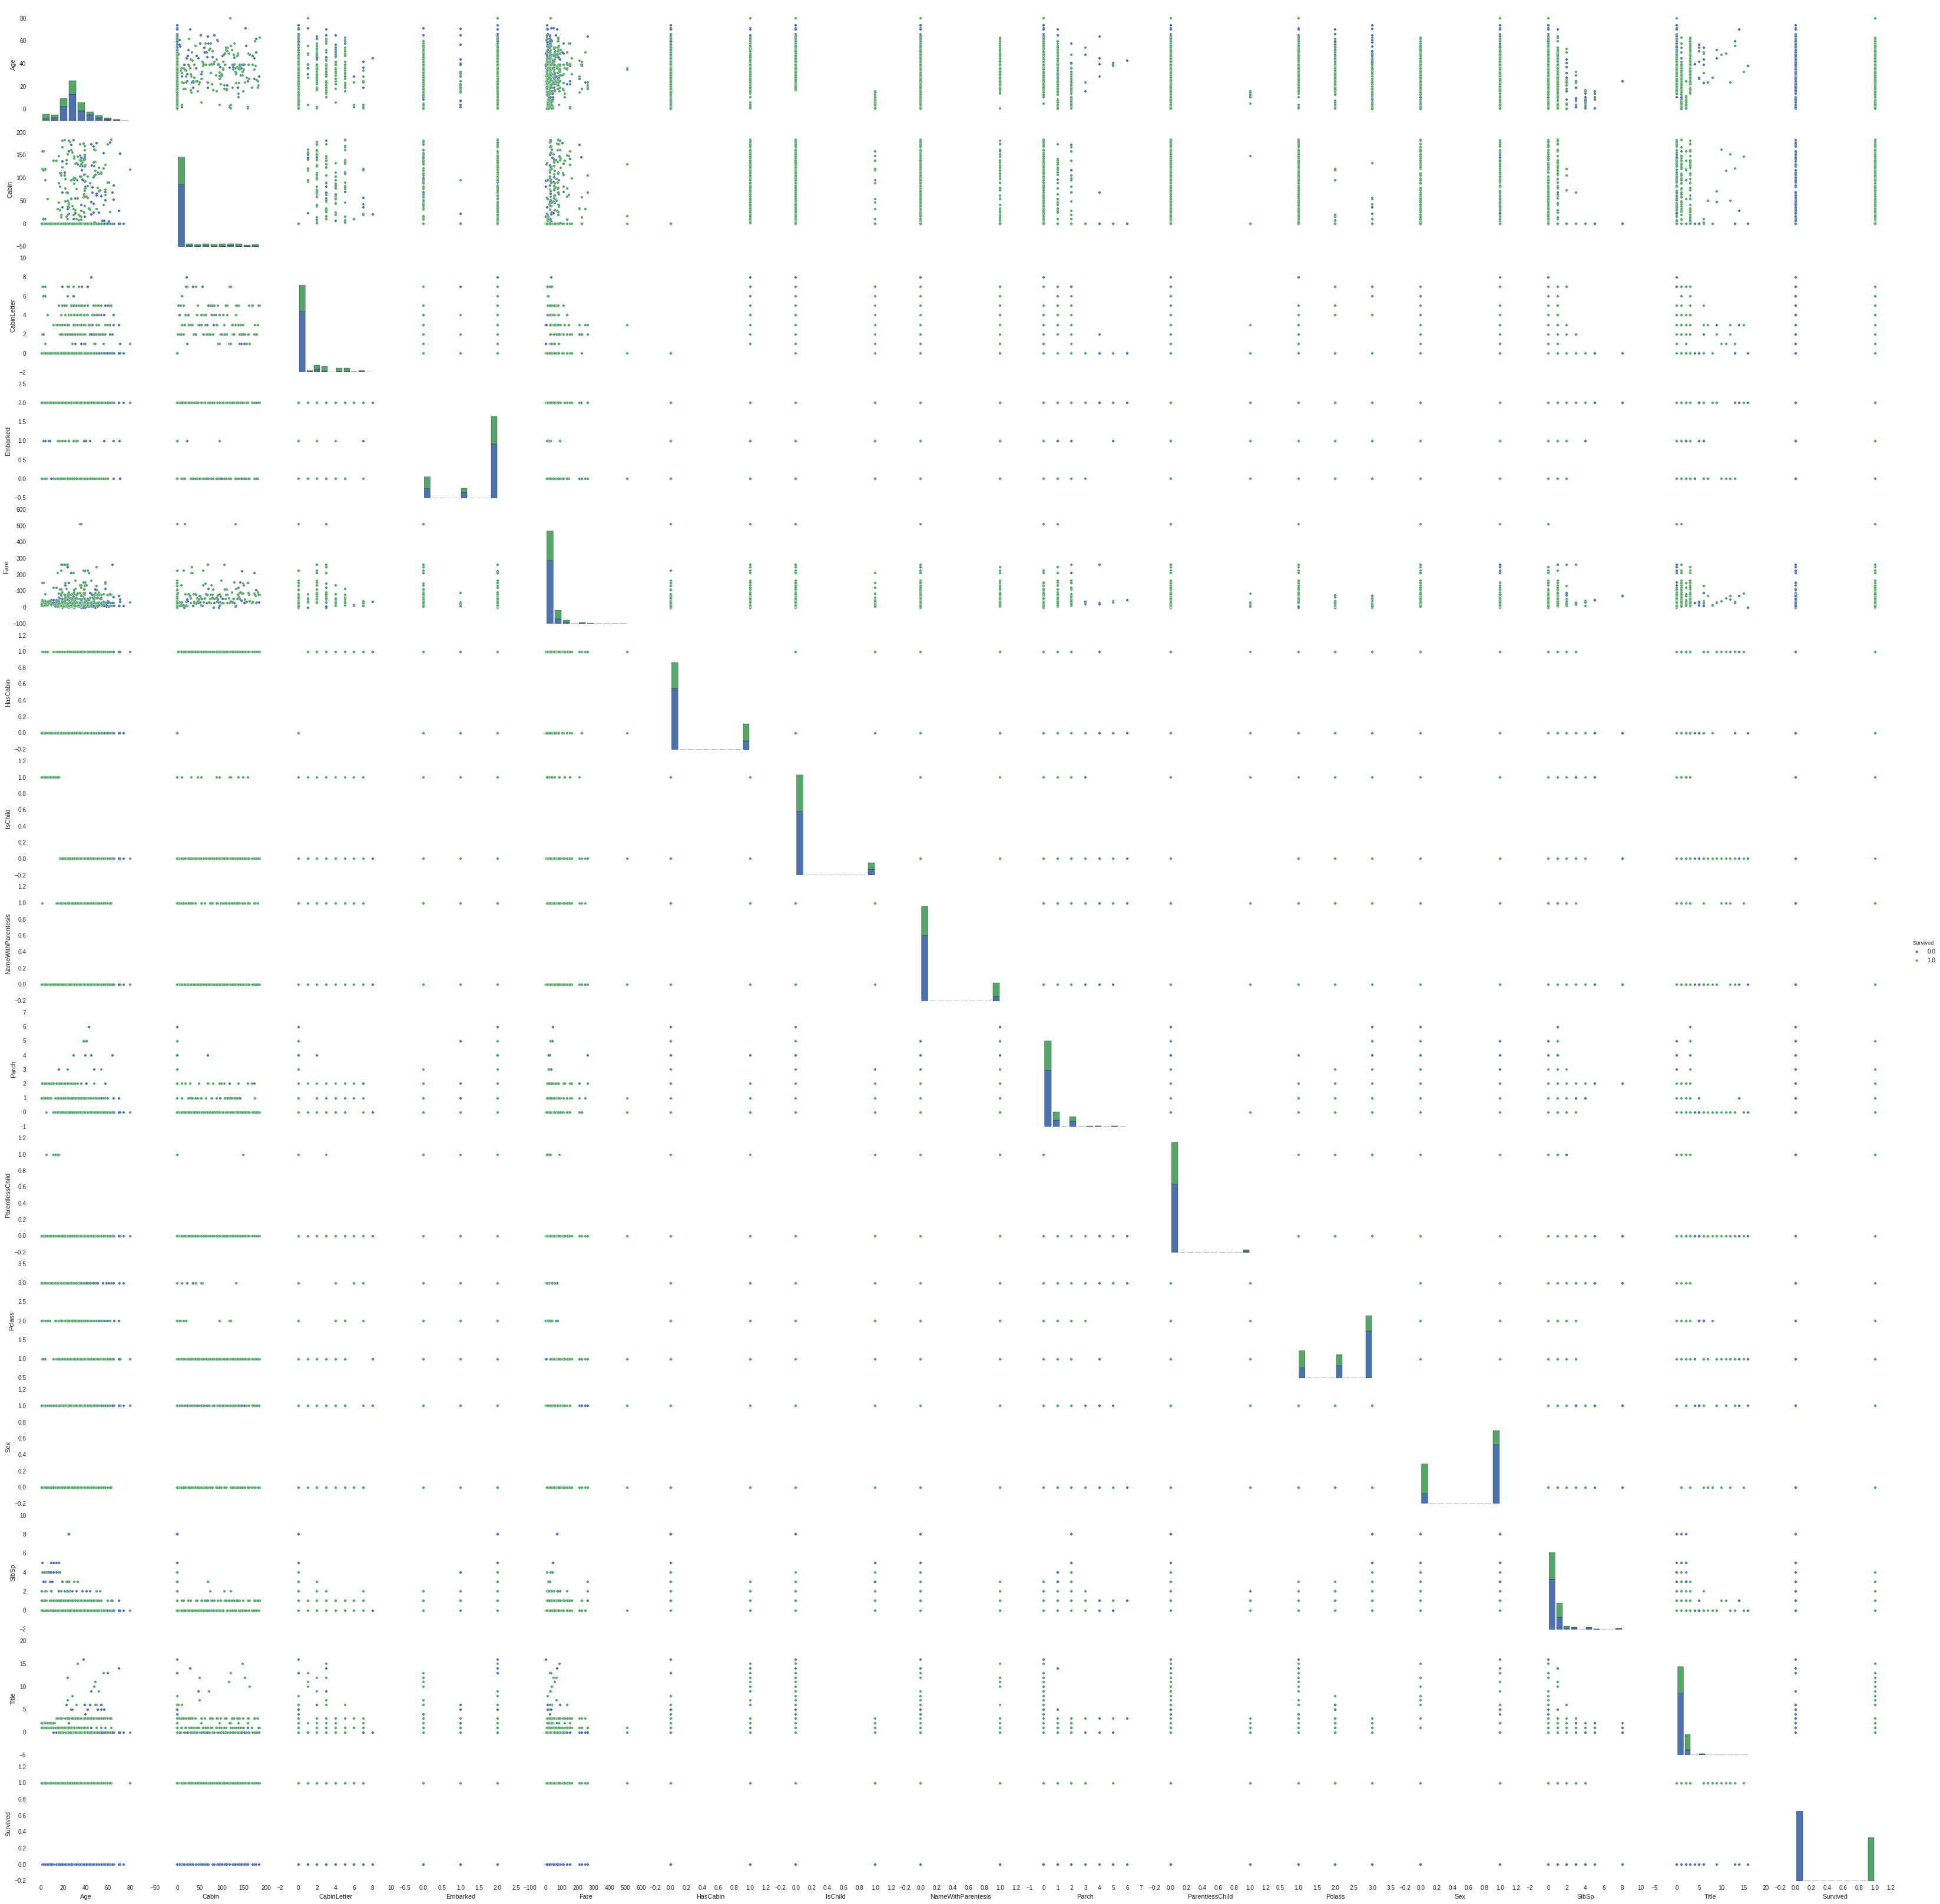

In [177]:
sns.pairplot(train[list(inputColumns)+['Survived']], hue='Survived')

###Let's visualize a 2D projection

In [178]:
svd = sklearn.decomposition.TruncatedSVD(n_components=2)
data_2d = svd.fit_transform(train_X)

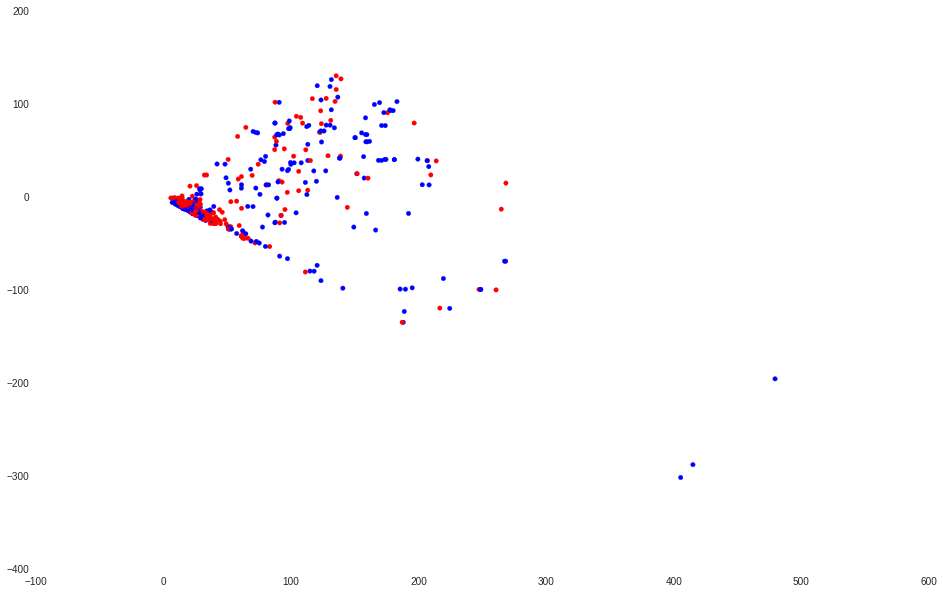

In [179]:
plt.figure(figsize=(16,10))
plt.scatter(data_2d[:,0], data_2d[:,1], color=['blue' if survived==1 else 'red' for survived in train['Survived']])
plt.show()

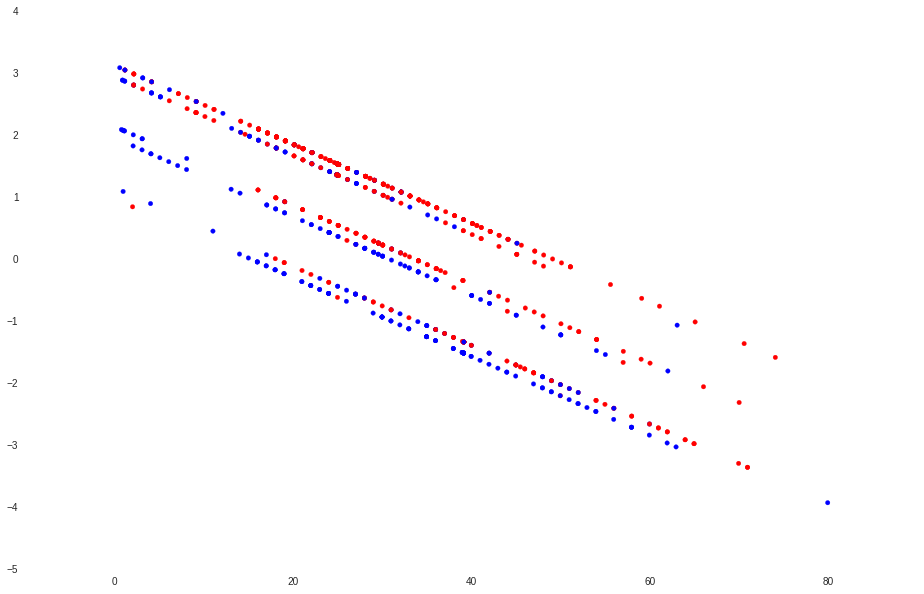

In [184]:
data_2d = svd.fit_transform(train[['Sex','Age','Pclass']])
plt.figure(figsize=(16,10))
plt.scatter(data_2d[:,0], data_2d[:,1], color=['blue' if survived==1 else 'red' for survived in train['Survived']])
plt.show()

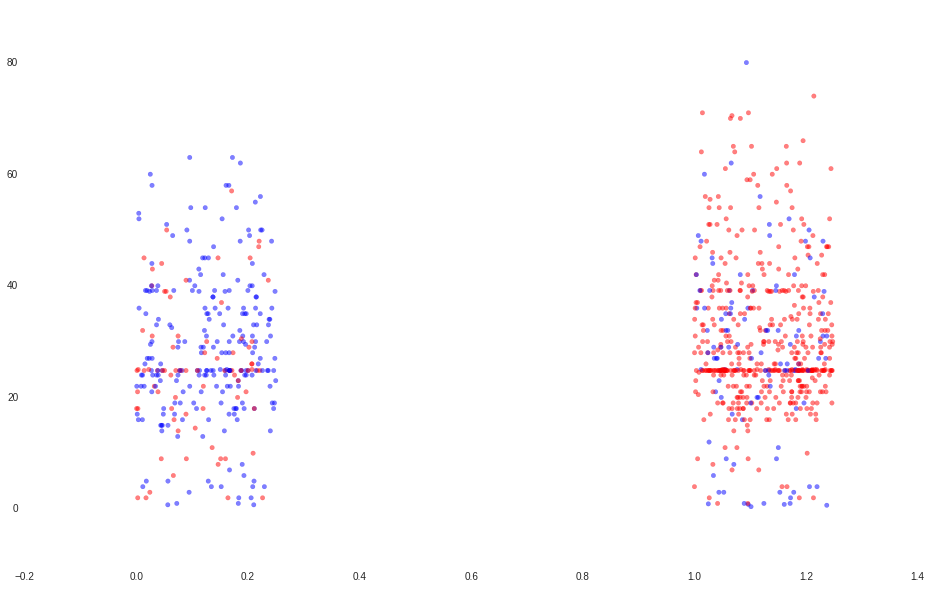

In [194]:
#data_2d = svd.fit_transform(train[['Sex','Age']])
plt.figure(figsize=(16,10))
plt.scatter([x+random.random()/4. for x in train['Sex'].values], 
            train['Age'], 
            color=['blue' if survived==1 else 'red' for survived in train['Survived']],
            alpha=0.5)
plt.show()

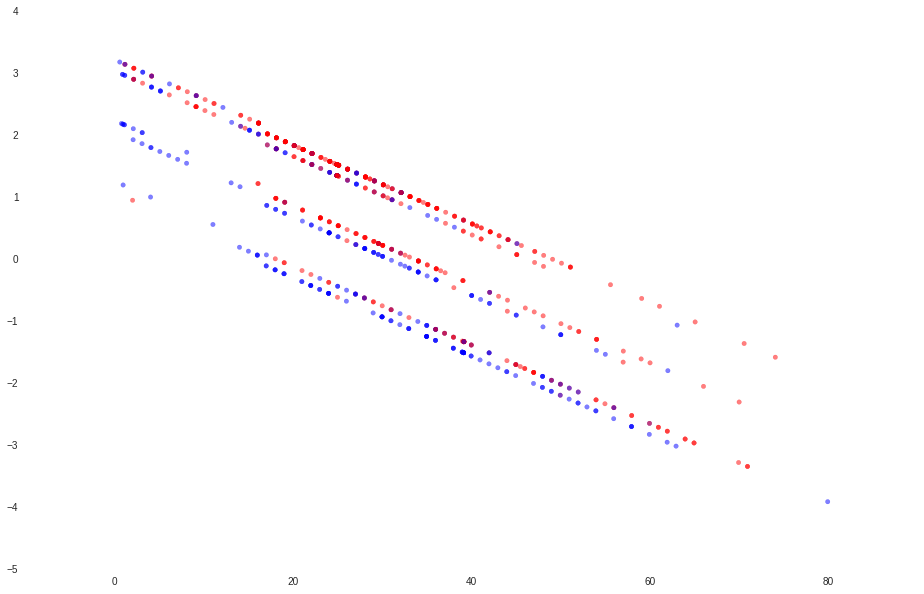

In [192]:
data_2d = svd.fit_transform(train[['Sex','Age','Pclass', 'IsChild']])
plt.figure(figsize=(16,10))
plt.scatter(data_2d[:,0], 
            data_2d[:,1], 
            color=['blue' if survived==1 else 'red' for survived in train['Survived']],
           alpha=0.5)
plt.show()

##  
##  
##  
##  

##  
##  
##  
##  

##  
##  
#RANDOM FOREST

In [46]:
trees2results = {}
for estimators in [2,5,10,20,50,100,200,500]:#,1000,2000]:
    print 'n_esitmators='+str(estimators)+' simulation=',
    classifier = RandomForestClassifier(n_estimators = estimators)
    totScores = []
    for simulation in range(10):
        print simulation,
        scores = cross_validation.cross_val_score(classifier, 
                                                  train_X, 
                                                  train_Y.values, 
                                                  cv=10)
        totScores.append(scores)
    print
    trees2results[estimators] = totScores

n_esitmators=1 simulation= 0 1 2 3 4 5 6 7 8 9
n_esitmators=5 simulation= 0 1 2 3 4 5 6 7 8 9
n_esitmators=10 simulation= 0 1 2 3 4 5 6 7 8 9
n_esitmators=20 simulation= 0 1 2 3 4 5 6 7 8 9
n_esitmators=50 simulation= 0 1 2 3 4 5 6 7 8 9
n_esitmators=100 simulation= 0 1 2 3 4 5 6 7 8 9
n_esitmators=200 simulation= 0 1 2 3 4 5 6 7 8 9
n_esitmators=500 simulation= 0 1 2 3 4 5 6 7 8 9


In [48]:
trees2medianResults = {}
for k in trees2results.keys():
    simulations = trees2results[k]
    medians = [np.median(simulation) for simulation in simulations]
    trees2medianResults[k] = medians

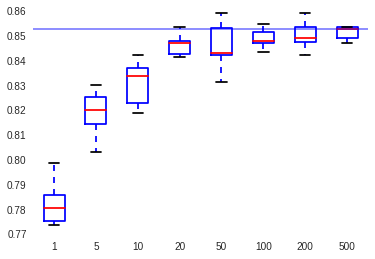

In [49]:
plt.boxplot([trees2medianResults[k] for k in sorted(trees2medianResults.keys())])
plt.axhline(np.max(  [np.median(v) for v in trees2medianResults.values()]   ), alpha=0.5)
plt.xticks(range(1, len(trees2medianResults)+1), sorted(trees2medianResults.keys()))
plt.show()

###Parameters tuning

In [222]:
for i in range(100):
    classifier = RandomForestClassifier()
    parametersDict = {'n_estimators':[30,50,100,500],
                      'max_features':['auto',None,'sqrt','log2'],
                      'min_samples_split':[1,2,5,10],
                      'min_samples_leaf':[1,2,5,10]}
    grid = sklearn.grid_search.GridSearchCV(estimator=classifier, param_grid=parametersDict, cv=5)
    grid.fit(train_X, train_Y.values)
    print grid.best_score_,
    print grid.best_params_    

0.843995510662 {'max_features': 'auto', 'min_samples_split': 1, 'n_estimators': 30, 'min_samples_leaf': 2}
0.842873176207 {'max_features': None, 'min_samples_split': 5, 'n_estimators': 50, 'min_samples_leaf': 5}
0.843995510662 {'max_features': None, 'min_samples_split': 1, 'n_estimators': 50, 'min_samples_leaf': 5}
0.846240179574 {'max_features': None, 'min_samples_split': 10, 'n_estimators': 30, 'min_samples_leaf': 2}
0.846240179574 {'max_features': None, 'min_samples_split': 10, 'n_estimators': 50, 'min_samples_leaf': 2}
0.846240179574 {'max_features': None, 'min_samples_split': 10, 'n_estimators': 50, 'min_samples_leaf': 5}
0.841750841751 {'max_features': None, 'min_samples_split': 10, 'n_estimators': 50, 'min_samples_leaf': 1}
0.843995510662 {'max_features': None, 'min_samples_split': 10, 'n_estimators': 100, 'min_samples_leaf': 5}


KeyboardInterrupt: 

In [621]:
n_estimators=70

classifier = RandomForestClassifier(n_estimators=n_estimators)
parametersDict = {'max_features':['auto',None,'sqrt','log2'],
                  'min_samples_split':[1,2,5,10,20],
                  'min_samples_leaf':[1,2,5]}
grid = GridSearchCV(estimator=classifier, 
                    param_grid=parametersDict, 
                    cv=5)

for i in range(10):
    grid.fit(data,train['Survived'].values)
    parameters = grid.best_params_
    print parameters
    
    classifier = RandomForestClassifier(n_estimators = n_estimators, 
                                            max_features=parameters['max_features'], 
                                            min_samples_split=parameters['min_samples_split'], 
                                            min_samples_leaf=parameters['min_samples_leaf'])
    
    simulations2results = {}
    for simulation in range(10): 
        print simulation
        
        results = cross_validation.cross_val_score(classifier,
                                                   data,
                                                   train['Survived'].values, 
                                                   cv=10)
        simulations2results[simulation] = results
    
    plt.boxplot([np.mean(simulations2results[k]) for k in sorted(simulations2results.keys())])
    plt.axhline(np.max(  [np.median(v) for v in simulations2results.values()]   ), alpha=0.5)
    plt.xticks(range(1, len(simulations2results)+1), sorted(simulations2results.keys()))
    plt.show()
    #print simulations2results.values()
    #print np.mean([np.mean(simulation) for simulation in simulations2results.values()])

KeyboardInterrupt: 

In [117]:
simulations2results = {}
for i in range(20):
    classifier = RandomForestClassifier(n_estimators = 70, 
                                        max_features='sqrt', 
                                        min_samples_split=2, 
                                        min_samples_leaf=2)
    print i,
    results = cross_validation.cross_val_score(classifier,data,train['Survived'].values, cv=10)
    simulations2results[i] = results

 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19


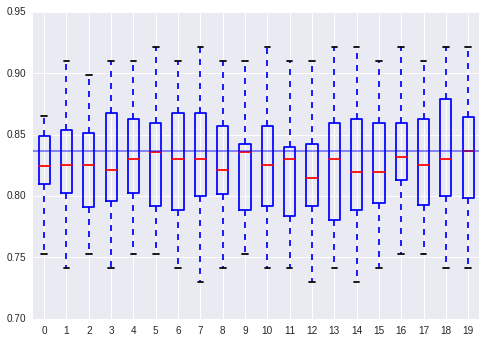

In [118]:
plt.boxplot([simulations2results[k] for k in sorted(simulations2results.keys())])
plt.axhline(np.max(  [np.median(v) for v in simulations2results.values()]   ), alpha=0.5)
plt.xticks(range(1, len(simulations2results)+1), sorted(simulations2results.keys()))
plt.show()

##ADABOOST

In [203]:
estimators2results = {}
for estimators in [2,5,10,20,40,50,60,80,100,200,500,1000,2000]:#,1000,2000]:
    print 'n_esitmators='+str(estimators)+' simulation=',
    classifier = sklearn.ensemble.AdaBoostClassifier(n_estimators=estimators)

    scores = cross_validation.cross_val_score(classifier, 
                                              train_X, 
                                              train_Y.values, 
                                              cv=10)
    print estimators, np.median(scores)
    estimators2results[estimators] = scores

n_esitmators=2 simulation= 2 0.780898876404
n_esitmators=5 simulation= 5 0.821161048689
n_esitmators=10 simulation= 10 0.814606741573
n_esitmators=20 simulation= 20 0.814606741573
n_esitmators=40 simulation= 40 0.814606741573
n_esitmators=50 simulation= 50 0.825842696629
n_esitmators=60 simulation= 60 0.819267109295
n_esitmators=80 simulation= 80 0.819267109295
n_esitmators=100 simulation= 100 0.824885086823
n_esitmators=200 simulation= 200 0.819203268641
n_esitmators=500 simulation= 500 0.82482124617
n_esitmators=1000 simulation= 1000 0.807903472932
n_esitmators=2000 simulation= 2000 0.81352145046


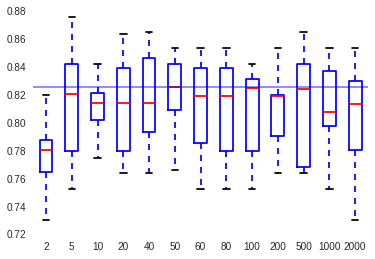

In [204]:
plt.boxplot([estimators2results[k] for k in sorted(estimators2results.keys())])
plt.axhline(np.max(  [np.median(v) for v in estimators2results.values()]   ), alpha=0.5)
plt.xticks(range(1, len(estimators2results)+1), sorted(estimators2results.keys()))
plt.show()

In [212]:
estimators2results = {}
for estimators in [1,2,3,4,5,6,7,8,9,10,20,50,100,200]:#,1000,2000]:
    print 'n_esitmators='+str(estimators)+' simulation=',
    
    
    classifier = sklearn.ensemble.AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators = 50,
                                                                                           max_features=None,
                                                                                           min_samples_split=5, 
                                                                                           min_samples_leaf=5), 
                                                     n_estimators=estimators)

    scores = cross_validation.cross_val_score(classifier, 
                                              train_X, 
                                              train_Y.values, 
                                              cv=10)
    print estimators, np.median(scores)
    estimators2results[estimators] = scores

n_esitmators=1 simulation= 1 0.847484678243
n_esitmators=2 simulation= 2 0.853102655771
n_esitmators=3 simulation= 3 0.841866700715
n_esitmators=4 simulation= 4 0.843570536829
n_esitmators=5 simulation= 5 0.837078651685
n_esitmators=6 simulation= 6 0.838014981273
n_esitmators=7 simulation= 7 0.820224719101
n_esitmators=8 simulation= 8 0.831460674157
n_esitmators=9 simulation= 9 0.832397003745
n_esitmators=10 simulation= 10 0.831460674157
n_esitmators=20 simulation= 20 0.820224719101
n_esitmators=50 simulation= 50 0.820224719101
n_esitmators=100 simulation=

KeyboardInterrupt: 

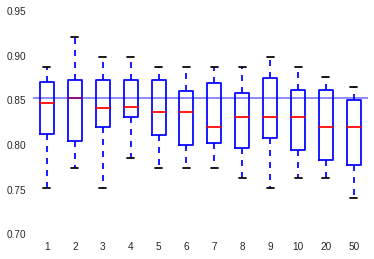

In [213]:
plt.boxplot([estimators2results[k] for k in sorted(estimators2results.keys())])
plt.axhline(np.max(  [np.median(v) for v in estimators2results.values()]   ), alpha=0.5)
plt.xticks(range(1, len(estimators2results)+1), sorted(estimators2results.keys()))
plt.show()

In [207]:
for i in range(10):
    classifier = sklearn.ensemble.AdaBoostClassifier(n_estimators=50)
    parametersDict = {
                      'learning_rate ':[1.0, 2.0],
                       'algorithm' : ['SAMME', 'SAMME.R']}
    grid = sklearn.grid_search.GridSearchCV(estimator=classifier, param_grid=parametersDict, cv=5)
    grid.fit(train_X, train_Y.values)
    print grid.best_score_,
    print grid.best_params_  

ValueError: Invalid parameter learning_rate  for estimator AdaBoostClassifier

##SVM

In [252]:
trainReduced = train_X.copy()

In [253]:
for column in trainReduced.columns:
    trainReduced[column] =  (trainReduced[column]-np.mean(trainReduced[column]))/np.std(trainReduced[column])
    
for column in trainReduced.columns:
    trainReduced[column] =  (trainReduced[column]-np.min(trainReduced[column]))/(np.max(trainReduced[column])-np.min(trainReduced[column]))

In [254]:
trainReduced.describe()

,Age,Cabin,CabinLetter,Embarked,Fare,HasCabin,IsChild,NameWithParentesis,Parch,ParentlessChild,Pclass,Sex,SibSp,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.362528,0.111317,0.096801,0.768238,0.062858,0.228956,0.112233,0.160494,0.063599,0.024691,0.654321,0.647587,0.065376,0.060466
std,0.166483,0.244400,0.201890,0.395752,0.096995,0.420397,0.315831,0.367270,0.134343,0.155270,0.418036,0.477990,0.137843,0.111844
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.271174,0.000000,0.000000,0.500000,0.015440,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000
50%,0.321438,0.000000,0.000000,1.000000,0.028213,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,0.459663,0.000000,0.000000,1.000000,0.060508,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.125000,0.062500
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [259]:
classifier = sklearn.svm.SVC()
scores = cross_validation.cross_val_score(classifier, 
                                          trainReduced, 
                                          train_Y.values, 
                                          cv=10)
print scores

[ 0.81111111  0.78888889  0.7752809   0.84269663  0.79775281  0.7752809
  0.76404494  0.74157303  0.80898876  0.76136364]


In [ ]:
tuned_parameters = [{'kernel': ['rbf','linear'], 
                     'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]
grid = sklearn.grid_search.GridSearchCV(sklearn.svm.SVC(), tuned_parameters, cv=10)
grid.fit(trainReduced, train_Y.values)
print grid.best_score_,
print grid.best_params_ 

# 
#  
#  
#  

 #Output creation

###Transform data

In [144]:
test['HasCabin'] = [0 if type(cabin)==float else 1 for cabin in test.Cabin.values]
test['CabinLetter'] = [0 if type(cabin)==float else cabin[0] for cabin in test.Cabin.values]
#cabinLetters = list(set(train['CabinLetter']))
test['CabinLetter'] = [cabinLetters.index(cabinLetter) for cabinLetter in test['CabinLetter']]    
test['Cabin'] = [0 if type(cabin)==float else (cabinsIds.index(cabin) if cabin in cabinsIds else len(cabinsIds)) for cabin in test.Cabin.values]
test['Sex'] = test['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

newAges = []
for i in range(len(test)):
    age = test.Age.values[i]
    if math.isnan(age):
        pclass = test.Pclass.values[i]
        age = class2meanAge[pclass]
    newAges.append(age) 
test['Age'] = newAges    

test['Embarked'] = test['Embarked'].fillna(mostCommonEmbarked)
test['Embarked'] = test['Embarked'].map( {'C': 0, 'Q': 1, 'S': 2} ).astype(int)

peopleTitles = []
for name in test.Name.values:
    for title in titles:
        if title in name:
            peopleTitles.append(titles.index(title))
            break
test['Title'] = peopleTitles

#TEST HAS A null FARE!!
for id in test[test.Fare.isnull()].PassengerId.values:
    pclass = test[test.PassengerId==id].Pclass.values[0]
    trainPclassFares = train[train.Pclass==pclass]['Fare'].values
    testPclassFares = test[test.Fare.notnull()][test.Pclass==pclass]['Fare'].values
    classMeanFare = np.mean(list(trainPclassFares)+list(testPclassFares))
    index = test[test.PassengerId==id].index.values[0]
    test.loc[index, 'Fare'] = classMeanFare
    
    
    
#Parentesis in name
test['NameWithParentesis'] = [1 if '(' in name else 0 for name in test['Name'].values]

In [145]:
print 'Total record: '+str(len(test))
print
print '[COLUMN] [NULL VALUES]'
for column in test.columns:
    print column, len(test[test[column].isnull()])

Total record: 418

[COLUMN] [NULL VALUES]
PassengerId 0
Pclass 0
Name 0
Sex 0
Age 0
SibSp 0
Parch 0
Ticket 0
Fare 0
Cabin 0
Embarked 0
HasCabin 0
CabinLetter 0
Title 0


In [146]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,CabinLetter,Title
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,0,1,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,0,2,0,0,3
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,0,1,0,0,0
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,0,2,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,0,2,0,0,3


###Create test_X

In [96]:
test_X = test[inputColumns]
test_X.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked,Fare,HasCabin,Title
0,3,1,34.5,0,0,1,7.8292,0,0
1,3,0,47.0,1,0,2,7.0000,0,3
2,2,1,62.0,0,0,1,9.6875,0,0
3,3,1,27.0,0,0,2,8.6625,0,0
4,3,0,22.0,1,1,2,12.2875,0,3


###Create a pool of classifiers

In [100]:
classifiersPool = []
#{'max_features': None, 'min_samples_split': 10, 'min_samples_leaf': 2}
#{'max_features': 'log2', 'min_samples_split': 10, 'min_samples_leaf': 1}
#{'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 2}



for i in range(200):  
    print i,
    classifier = RandomForestClassifier(n_estimators = random.choice([50,100,500]), 
                                    max_features=random.choice([None, 'log2', 'auto']), 
                                    min_samples_split=random.choice([10,2]), 
                                    min_samples_leaf=random.choice([2,1]))
    classifier.fit(train_X,train_Y.values)
    classifiersPool.append(classifier)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199


In [101]:
totalPredictions = []
for classifier in classifiersPool:
    predictions = classifier.predict(test_X)
    totalPredictions.append(predictions)

In [102]:
finalValues = []
for i in range(len(test_X)):
    values = [prediction[i] for prediction in totalPredictions]
    finalValues.append( int(np.round(np.mean(values))) )

###Create output file

In [103]:
import csv

myfile = open('submissions/4.csv', 'wb')
wr = csv.writer(myfile)
wr.writerow(['PassengerId','Survived'])
for i in range(len(finalValues)):
    id = test['PassengerId'].values[i]
    prediction = finalValues[i]
    wr.writerow([id,prediction])